In [2]:
import matplotlib
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from dateutil.parser import parse
from datetime import timedelta

In [3]:
results_dir = "results/minority"

results = []
for d in os.listdir(results_dir):
    for f in os.listdir(f"{results_dir}/{d}"):
        if f.endswith("json") and f.startswith("PodStartupLatency"):
            results.append((f"{d}/{f}", f"{d}/config.json"))

df = pd.DataFrame()
for (r, config) in results:
    print(config)
    with open(f"{results_dir}/{config}", "r") as c:
        with open(f"{results_dir}/{r}") as r:
            
            config_json = json.loads(c.read())
            results_json = json.loads(r.read())
            
            rows_json = defaultdict(list)

            for item in results_json["dataItems"]:
                name = item["labels"]["Metric"]
                data = item["raw"]
                rows_json["metric"] += [name for _ in range(len(data))]
                
                starts = [parse(d["start"]) for d in data]
                start = min(starts)
                rows_json["start"] += [parse(d["start"]) - start for d in data]
                rows_json["start_ms"] += [(parse(d["start"])- start) / timedelta(milliseconds=1)  for d in data]

                rows_json["end"] += [parse(d["end"]) - start for d in data]
                rows_json["end_ms"] += [(parse(d["end"]) - start) / timedelta(milliseconds=1) for d in data]
                
                rows_json["measurement"] += [(parse(d["end"]) - parse(d["start"])) / timedelta(milliseconds=1) for d in data]

            for k, v in config_json.items():
                rows_json[k] = [v for _ in range(len(rows_json["metric"]))]
            
            d = pd.DataFrame(rows_json)
            df = df.append(d, ignore_index=True)

cluster_size=5,repeat=1/config.json
cluster_size=3,repeat=1/config.json
cluster_size=3,repeat=2/config.json
cluster_size=7,repeat=2/config.json
cluster_size=5,repeat=2/config.json


In [4]:
df.describe()

,start,start_ms,end,end_ms,measurement,cluster_size,repeat
count,1943,1943.000000,1943,1943.000000,1943.000000,1943.000000,1943.000000
mean,0 days 00:00:17.160531555,17160.531555,0 days 00:00:27.888339196,27888.339197,10727.807641,4.591354,1.598559
std,0 days 00:00:14.119240007,14119.240008,0 days 00:00:18.834847791,18834.847792,15424.866121,1.492780,0.490316
min,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000,0.000000,3.000000,1.000000
25%,0 days 00:00:06,6000.000000,0 days 00:00:13.125272,13125.272000,0.000000,3.000000,1.000000
50%,0 days 00:00:14,14000.000000,0 days 00:00:27,27000.000000,1583.102000,5.000000,2.000000
75%,0 days 00:00:26,26000.000000,0 days 00:00:41.203374500,41203.374500,20384.257000,5.000000,2.000000
max,0 days 00:02:49.409956,169409.956000,0 days 00:02:49.512147,169512.147000,120451.634000,7.000000,2.000000


In [5]:
df.head()

,metric,start,start_ms,end,end_ms,measurement,cluster_size,repeat
0,pod_startup,0 days 00:00:06,6000.0,0 days 00:00:17.949689,17949.689,11949.689,5,1
1,pod_startup,0 days 00:00:07,7000.0,0 days 00:00:23.678844,23678.844,16678.844,5,1
2,pod_startup,0 days 00:00:00,0.0,0 days 00:00:16.985071,16985.071,16985.071,5,1
3,pod_startup,0 days 00:00:05,5000.0,0 days 00:00:22.846538,22846.538,17846.538,5,1
4,pod_startup,0 days 00:00:08,8000.0,0 days 00:00:26.636269,26636.269,18636.269,5,1


In [6]:
cluster_size_counts = sorted(list(set(df["cluster_size"])))
data_per_cluster_size = [df[df["cluster_size"] == i] for i in cluster_size_counts]

In [7]:
def stripbar(data, name):
    os.makedirs("plots", exist_ok=True)
    os.makedirs("plots/minority", exist_ok=True)

    repeats = sorted(list(set(df["repeat"])))
    g = sns.FacetGrid(data, col="cluster_size")
    np.random.seed(100)
    g.map(sns.stripplot, "repeat", "measurement", order=repeats)
    np.random.seed(100)
    g.map(sns.barplot, "repeat", "measurement", alpha=0.2, order=repeats)
    g.set(xlabel="Repeat", ylabel="Duration (ms)")
    plt.savefig(f"plots/minority/{name}-bar.svg")
    plt.savefig(f"plots/minority/{name}-bar.pdf")
    plt.savefig(f"plots/minority/{name}-bar.jpg")
    plt.show()

    g = sns.FacetGrid(data, col="cluster_size")
    g.map_dataframe(sns.scatterplot, x="start_ms", y="measurement", alpha=0.5, hue="repeat")
    g.add_legend()
    g.set(xlabel="Time since start (ms)", ylabel="Duration (ms)")
    plt.savefig(f"plots/minority/{name}-scatter.svg")
    plt.savefig(f"plots/minority/{name}-scatter.pdf")
    plt.savefig(f"plots/minority/{name}-scatter.jpg")
    plt.show()

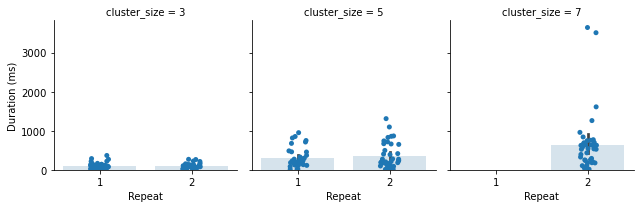

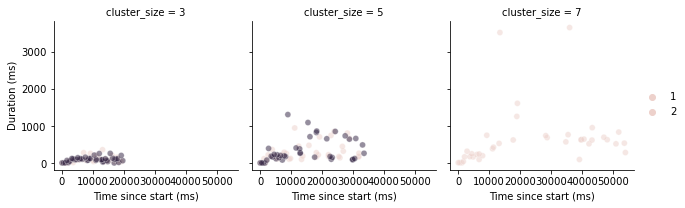

In [8]:
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]
stripbar(data, "scheduling_time")

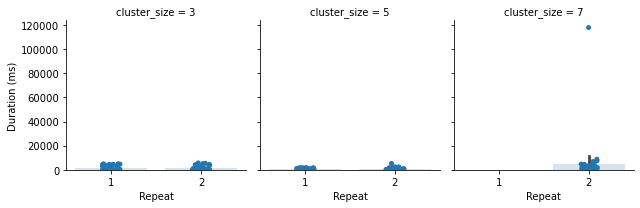

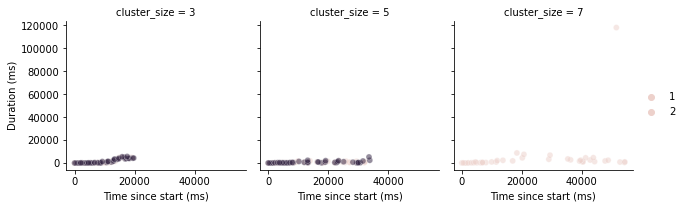

In [9]:
data = df[np.isin(df.metric, ["client_schedule_to_client_started"])]
stripbar(data, "kubelet_pickup")

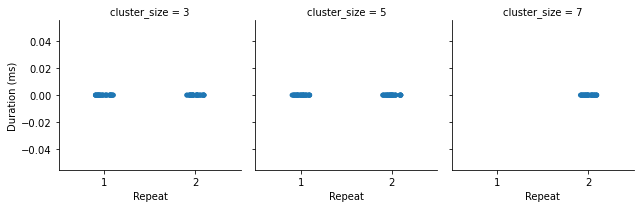

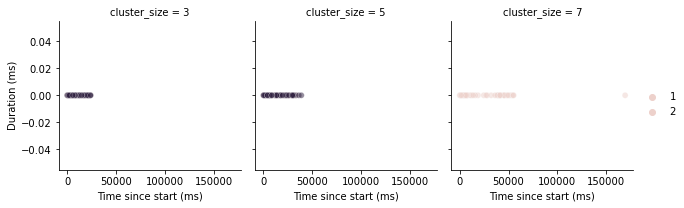

In [10]:
data = df[np.isin(df.metric, ["client_started_to_client_initialized"])]
stripbar(data, "initialize")

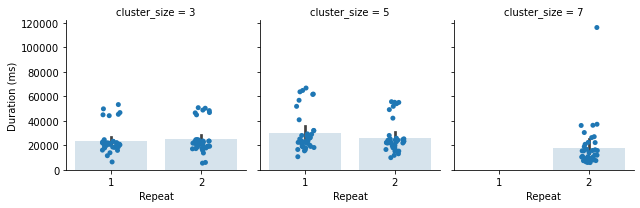

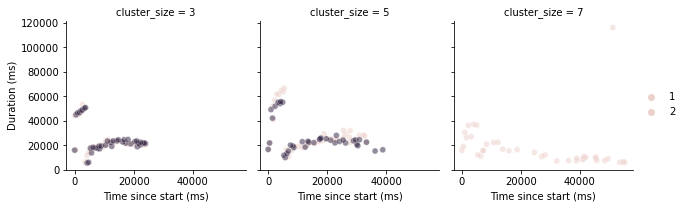

In [11]:
data = df[np.isin(df.metric, ["client_initialized_to_client_containersready"])]
stripbar(data, "container_start")

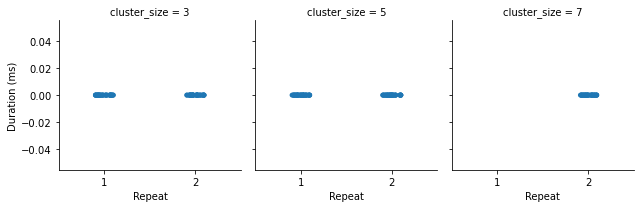

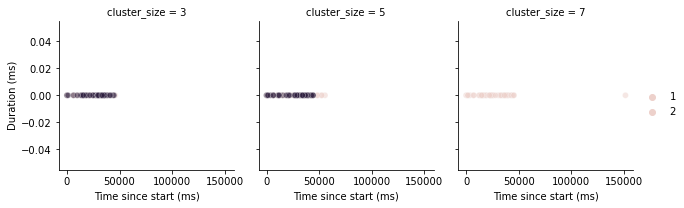

In [12]:
data = df[np.isin(df.metric, ["client_containersready_to_client_podready"])]
stripbar(data, "pod_ready")

                           start      start_ms                        end  \
count                        195    195.000000                        195   
mean   0 days 00:00:14.505107589  14505.107590  0 days 00:00:14.807035625   
std    0 days 00:00:12.231978936  12231.978936  0 days 00:00:12.407861816   
min              0 days 00:00:00      0.000000     0 days 00:00:00.012262   
25%    0 days 00:00:05.119334500   5119.334500     0 days 00:00:05.251594   
50%       0 days 00:00:11.976769  11976.769000     0 days 00:00:12.109461   
75%    0 days 00:00:19.009032500  19009.032500     0 days 00:00:19.302862   
max       0 days 00:00:53.997843  53997.843000     0 days 00:00:54.289228   

             end_ms  measurement  cluster_size      repeat  
count    195.000000   195.000000    195.000000  195.000000  
mean   14807.035626   301.928036      4.600000    1.600000  
std    12407.861817   436.509385      1.500515    0.491159  
min       12.262000    10.229000      3.000000    1.000000  
2

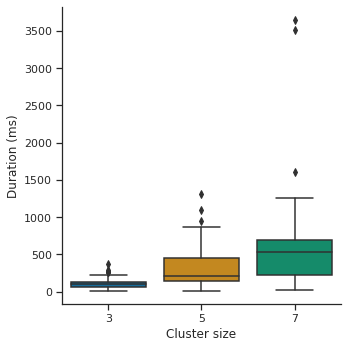

In [19]:
# time for scheduler to get watch event, process it and write back
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]
# data = data[data.measurement < 5000] # cut off outliers
print(data.describe())
# data = data.sort_values("image")
# data = data[data.partitioned < 2]
data = data.rename(columns={"cluster_size": "Cluster size"})

name = "scheduling_delay"

sns.set(font_scale=1)
sns.set_style("ticks")

os.makedirs("plots", exist_ok=True)
os.makedirs("plots/minority", exist_ok=True)
# delays = sorted(list(set(data.partitioned)))
np.random.seed(100)
# sns.stripplot(data=data, x="masters", y="measurement", hue="image", dodge=True)
np.random.seed(100)
# sns.barplot(data=data, x="masters", y="measurement", alpha=0.2, hue="image")

sns.set_palette("colorblind")

ax = sns.catplot(kind="box", data=data, x="Cluster size", y="measurement")

ax.set(xlabel="Cluster size", ylabel="Duration (ms)")

plt.savefig(f"plots/minority/{name}-box.svg")
plt.savefig(f"plots/minority/{name}-box.pdf")
plt.savefig(f"plots/minority/{name}-box.jpg")
plt.show()